# Time series forecasting with DeepAR - Synthetic data

DeepAR is a supervised learning algorithm for forecasting scalar time series. This notebook demonstrates how to prepare a dataset of time series for training DeepAR and how to use the trained model for inference.

In [1]:
import time
import numpy as np
np.random.seed(1)
import pandas as pd
import json
import matplotlib.pyplot as plt

We will use the sagemaker client library for easy interface with sagemaker and s3fs for uploading the training data to S3. (Use `pip` to install missing libraries)

In [2]:
import boto3
import s3fs
import sagemaker
from sagemaker import get_execution_role

Let's start by specifying:
- The S3 bucket prefix that you want to use for training and model data. Here we use the default bucket with `sagemaker_session.default_bucket()`, but you can change this to a bucket of your choosing. This should be within the same region as the Notebook Instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these. Here we use the `get_execution_role` function to obtain the role arn which was specified when creating the notebook.

In [3]:
prefix = 'sagemaker/DEMO-deepar'

sagemaker_session = sagemaker.Session()
role = get_execution_role()
bucket = sagemaker_session.default_bucket()

s3_data_path = "{}/{}/data".format(bucket, prefix)
s3_output_path = "{}/{}/output".format(bucket, prefix)

Next, we configure the container image to be used for the region that we are running in.

In [4]:
from sagemaker.amazon.amazon_estimator import get_image_uri
image_name = get_image_uri(boto3.Session().region_name, 'forecasting-deepar')

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


### Generating and uploading data

In this toy example we want to train a model that can predict the next 48 points of syntheticly generated time series.
The time series that we use have hourly granularity.

In [5]:
freq = 'H'
prediction_length = 48

We also need to configure the so-called `context_length`, which determines how much context of the time series the model should take into account when making the prediction, i.e. how many previous points to look at. A typical value to start with is around the same size as the `prediction_length`. In our example we will use a longer `context_length` of `72`. Note that in addition to the `context_length` the model also takes into account the values of the time series at typical seasonal windows e.g. for hourly data the model will look at the value of the series 24h ago, one week ago one month ago etc. So it is not necessary to make the `context_length` span an entire month if you expect monthly seasonalities in your hourly data.

In [6]:
context_length = 72

For this notebook, we will generate 200 noisy time series, each consisting of 400 data points and with seasonality of 24 hours. In our dummy example, all time series start at the same time point `t0`. When preparing your data, it is important to use the correct start point for each time series, because the model uses the time-point as a frame of reference, which enables it to learn e.g. that weekdays behave differently from weekends.

In [7]:
t0 = '2016-01-01 00:00:00'
data_length = 400
num_ts = 200
period = 24

Each time series will be a noisy sine wave with a random level. 

In [8]:
time_series = []
for k in range(num_ts):
    level = 10 * np.random.rand()
    seas_amplitude = (0.1 + 0.3*np.random.rand()) * level
    sig = 0.05 * level # noise parameter (constant in time)
    time_ticks = np.array(range(data_length))
    source = level + seas_amplitude*np.sin(time_ticks*(2*np.pi)/period)
    noise = sig*np.random.randn(data_length)
    data = source + noise
    index = pd.date_range(start=t0, freq=freq, periods=data_length)
    time_series.append(pd.Series(data=data, index=index))

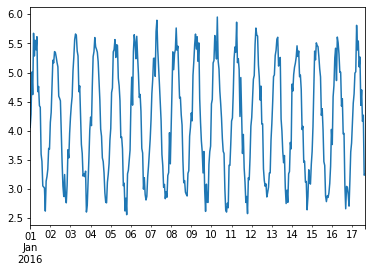

In [9]:
time_series[0].plot()
plt.show()

Often one is interested in tuning or evaluating the model by looking at error metrics on a hold-out set. For other machine learning tasks such as classification, one typically does this by randomly separating examples into train/test sets. For forecasting it is important to do this train/test split in time rather than by series.

In this example, we will leave out the last section of each of the time series we just generated and use only the first part as training data. Here we will predict 48 data points, therefore we take out the trailing 48 points from each time series to define the training set. The test set contains the full range of each time series.

In [10]:
time_series_training = []
for ts in time_series:
    time_series_training.append(ts[:-prediction_length])

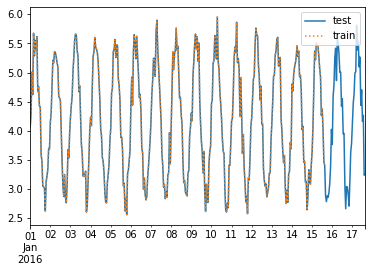

In [11]:
time_series[0].plot(label='test')
time_series_training[0].plot(label='train', ls=':')
plt.legend()
plt.show()

The following utility functions convert `pandas.Series` objects into the appropriate JSON strings that DeepAR can consume. We will use these to write the data to S3.

In [12]:
def series_to_obj(ts, cat=None):
    obj = {"start": str(ts.index[0]), "target": list(ts)}
    if cat is not None:
        obj["cat"] = cat
    return obj

def series_to_jsonline(ts, cat=None):
    return json.dumps(series_to_obj(ts, cat))

In [13]:
encoding = "utf-8"
s3filesystem = s3fs.S3FileSystem()

with s3filesystem.open(s3_data_path + "/train/train.json", 'wb') as fp:
    for ts in time_series_training:
        fp.write(series_to_jsonline(ts).encode(encoding))
        fp.write('\n'.encode(encoding))

with s3filesystem.open(s3_data_path + "/test/test.json", 'wb') as fp:
    for ts in time_series:
        fp.write(series_to_jsonline(ts).encode(encoding))
        fp.write('\n'.encode(encoding))

### Train a model

We can now define the estimator that will launch the training job.

In [14]:
estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_name=image_name,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.c4.xlarge',
    base_job_name='DEMO-deepar',
    output_path="s3://" + s3_output_path
)

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


Next we need to set some hyperparameters: for example, frequency of the time series used, number of data points the model will look at in the past, number of predicted data points. The other hyperparameters concern the model to train (number of layers, number of cells per layer, likelihood function) and the training options such as number of epochs, batch size, and learning rate. Refer to the documentation for a full description of the available parameters.

In [15]:
hyperparameters = {
    "time_freq": freq,
    "context_length": str(context_length),
    "prediction_length": str(prediction_length),
    "num_cells": "40",
    "num_layers": "3",
    "likelihood": "gaussian",
    "epochs": "20",
    "mini_batch_size": "32",
    "learning_rate": "0.001",
    "dropout_rate": "0.05",
    "early_stopping_patience": "10"
}

In [16]:
estimator.set_hyperparameters(**hyperparameters)

We are ready to launch the training job. SageMaker will start an EC2 instance, download the data from S3, start training the model and save the trained model.

If you provide the `test` data channel, as we do in this example, DeepAR will also calculate accuracy metrics for the trained model on this test data set. This is done by predicting the last `prediction_length` points of each time series in the test set and comparing this to the actual value of the time series. The computed error metrics will be included as part of the log output.

**Note:** the next cell may take a few minutes to complete, depending on data size, model complexity, and training options.

In [17]:
data_channels = {
    "train": "s3://{}/train/".format(s3_data_path),
    "test": "s3://{}/test/".format(s3_data_path)
}

estimator.fit(inputs=data_channels)

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


2020-09-26 20:02:49 Starting - Starting the training job...
2020-09-26 20:02:51 Starting - Launching requested ML instances......
2020-09-26 20:04:19 Starting - Preparing the instances for training......
2020-09-26 20:05:14 Downloading - Downloading input data......
2020-09-26 20:06:20 Training - Training image download completed. Training in progress..Arguments: train
[09/26/2020 20:06:22 INFO 140123645937472] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likelihood': u'student-t', u'early_stopping_patienc

### Create endpoint and predictor

Now that we have trained a model, we can use it to perform predictions by deploying it to an endpoint.

**Note:** remember to delete the endpoint after running this experiment. A cell at the very bottom of this notebook will do that: make sure you run it at the end.

In [18]:
job_name = estimator.latest_training_job.name

endpoint_name = sagemaker_session.endpoint_from_job(
    job_name=job_name,
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
    deployment_image=image_name,
    role=role
)

-----------------!

To query the endpoint and perform predictions, we can define the following utility class: this allows making requests using `pandas.Series` objects rather than raw JSON strings.

In [19]:
class DeepARPredictor(sagemaker.predictor.RealTimePredictor):

    def set_prediction_parameters(self, freq, prediction_length):
        """Set the time frequency and prediction length parameters. This method **must** be called
        before being able to use `predict`.
        
        Parameters:
        freq -- string indicating the time frequency
        prediction_length -- integer, number of predicted time points
        
        Return value: none.
        """
        self.freq = freq
        self.prediction_length = prediction_length
        
    def predict(self, ts, cat=None, encoding="utf-8", num_samples=100, quantiles=["0.1", "0.5", "0.9"]):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.
        
        Parameters:
        ts -- list of `pandas.Series` objects, the time series to predict
        cat -- list of integers (default: None)
        encoding -- string, encoding to use for the request (default: "utf-8")
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])
        
        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        prediction_times = [x.index[-1]+pd.Timedelta(1, unit=self.freq) for x in ts]
        req = self.__encode_request(ts, cat, encoding, num_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, prediction_times, encoding)
    
    def __encode_request(self, ts, cat, encoding, num_samples, quantiles):
        instances = [series_to_obj(ts[k], cat[k] if cat else None) for k in range(len(ts))]
        configuration = {"num_samples": num_samples, "output_types": ["quantiles"], "quantiles": quantiles}
        http_request_data = {"instances": instances, "configuration": configuration}
        return json.dumps(http_request_data).encode(encoding)
    
    def __decode_response(self, response, prediction_times, encoding):
        response_data = json.loads(response.decode(encoding))
        list_of_df = []
        for k in range(len(prediction_times)):
            prediction_index = pd.date_range(start=prediction_times[k], freq=self.freq, periods=self.prediction_length)
            list_of_df.append(pd.DataFrame(data=response_data['predictions'][k]['quantiles'], index=prediction_index))
        return list_of_df

In [20]:
predictor = DeepARPredictor(
    endpoint=endpoint_name,
    sagemaker_session=sagemaker_session,
    content_type="application/json"
)
predictor.set_prediction_parameters(freq, prediction_length)

### Make predictions and plot results

Now we can use the previously created `predictor` object. For simplicity, we will predict only the first few time series used for training, and compare the results with the actual data we kept in the test set.

In [21]:
list_of_df = predictor.predict(time_series_training[:5])
actual_data = time_series[:5]

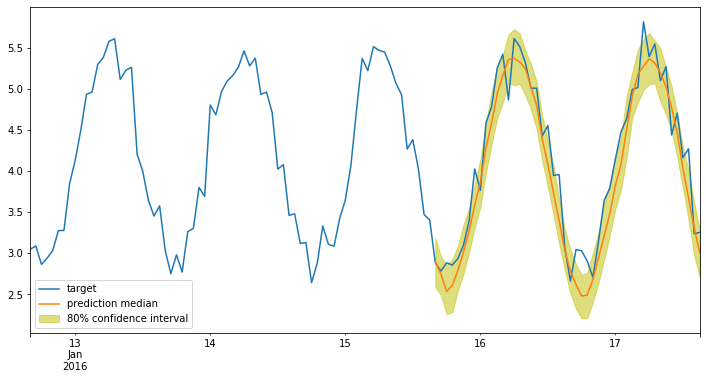

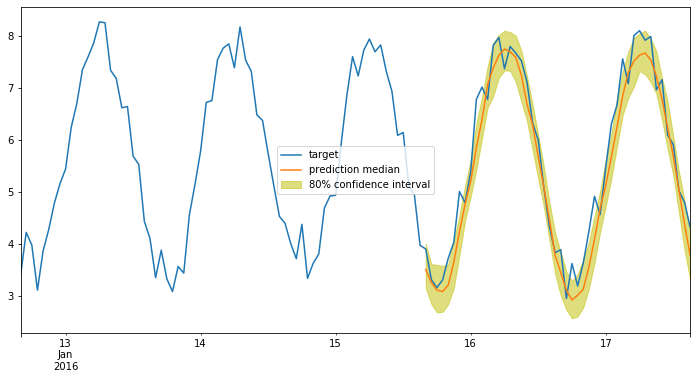

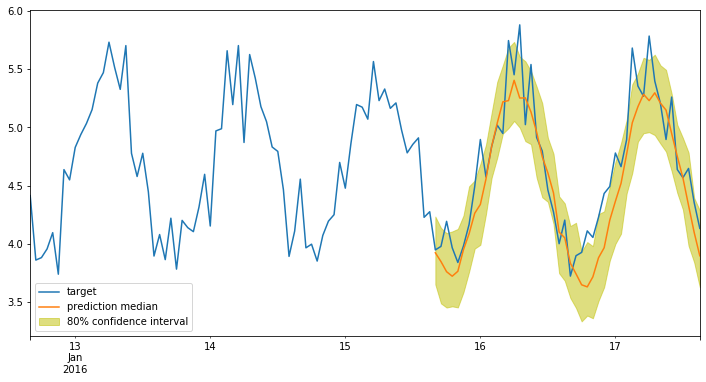

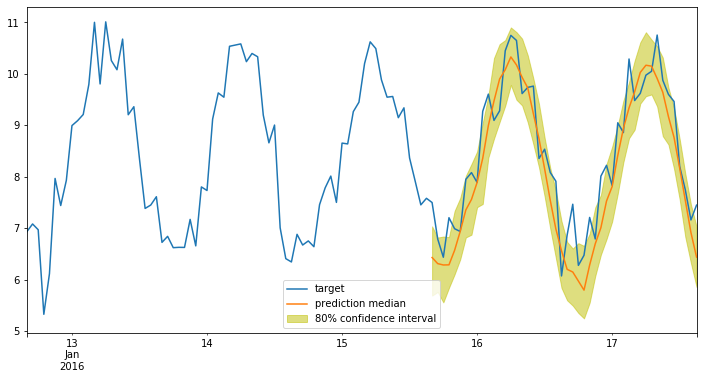

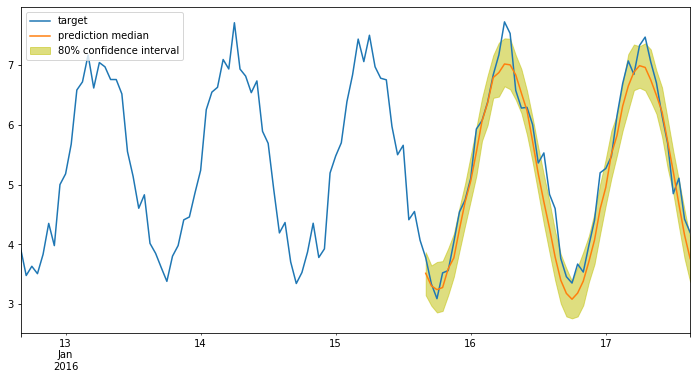

In [22]:
for k in range(len(list_of_df)):
    plt.figure(figsize=(12,6))
    actual_data[k][-prediction_length-context_length:].plot(label='target')
    p10 = list_of_df[k]['0.1']
    p90 = list_of_df[k]['0.9']
    plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
    list_of_df[k]['0.5'].plot(label='prediction median')
    plt.legend()
    plt.show()

### Delete endpoint

In [23]:
sagemaker_session.delete_endpoint(endpoint_name)